In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib.backends.backend_pdf import PdfPages

plt.style.use("ggplot")

# Task 2.16: Historic time series for TOTN and TOTP

NIBIO can only generate input data in the new format from 2013 onwards, so data processing for TEOTIL3 has focused on 2013 to present. However, Miljødirektoratet would like to extend the series for TOTN and TOTP back to 1990 by comparison with TEOTIL2.

This notebook generates the same plots produced for the annual TEOTIL2 reports (e.g. [here](https://www.miljodirektoratet.no/publikasjoner/2023/januar-2023/kildefordelte-tilforsler-av-nitrogen-og-fosfor-til-norske-kystomrader-i-2021-tabeller-figurer-og-kart/)). However, predictions from TEOTIL2 are "bias-corrected" using data from TEOTIL3 for the period of overlap. This is done to avoid large step changes.

The bias correction is done using a very simple approach

$$F = \frac{TEOTIL3_{avg}}{TEOTIL2_{avg}}$$

where $TEOTIL3_{avg}$ is the mean of TEOTIL3 results for 2013 to 2022; $TEOTIL2_{avg}$ is the mean of TEOTIL2 results for 2013 to 2022; and $F$ is a correction applied to the historic TEOTIL2 series for 1990 to 2012

$$S_{cor} = F \times S_{raw}$$

## 1. Aggregate data to classes used in report

The functions below aggregate output from TEOTIL2 and TEOTIL3 to match regions and sectors defined in the TEOTIL2 reports.

In [2]:
def aggregate_regions(df, par, out_fold=None, model="teotil3"):
    """Sum TEOTIL output for the main catchments for each region defined in the
       report.

    Args
        df:            Dataframe of results aggregated to the correct column names
                       for the report
        par:           Str. Either 'n' or 'p'
        out_fold:      None or str. Default None. Folder to save CSVs to, if desired

    Returns
        Dict of dataframes. Optionally, results for each region are saved to CSV.
    """
    assert par in ("n", "p")

    # Map regions used in report to main catchments
    # Intervals are "Python-style" i.e. include first but not last element in range
    regions_dict = {
        # Definerte kystavsnitt (chapter 5)
        "Norges kystområder": [1, 248, 315],
        "Sverige – Strømtangen fyr": [1, 3],
        "Indre Oslofjord": [5, 10],
        "Svenskegrensa – Lindesnes": [1, 24],
        "Lindesnes – Stad": [24, 92],
        "Stad – Russland": [92, 248],
        # Norske vannregioner (chapter 6)
        "Glomma": [1, 11],
        "Vest-Viken": [11, 18],
        "Agder": [18, 27],
        "Rogaland": [27, 41],
        "Hordaland": [41, 68],
        "Sogn og Fjordane": [68, 92],
        "Møre og Romsdal": [92, 117],
        "Trøndelag": [117, 144],
        "Nordland": [144, 186],
        "Troms": [186, 211],
        "Finnmark": [211, 248],
        # Norske forvaltingsplanområder (chapter 7)
        "Nordsjøen": [1, 91, 315],  # 315 is included here too in John Rune's Access db
        "Norskehavet": [91, 171],
        "Barentshavet": [171, 248],
    }

    result_dict = {}
    for region, catches in regions_dict.items():
        if len(catches) == 2:
            catch_list = list(range(catches[0], catches[1]))
        else:
            catch_list = list(range(catches[0], catches[1])) + [catches[2]]
        catch_list = [f"{i:03d}." for i in catch_list]

        reg_df = df.query("regine in @catch_list").copy()
        reg_df = reg_df.groupby("År").sum(numeric_only=True).reset_index()

        if model == "teotil2":
            legacy_csv = f"/home/jovyan/projects/teotil2_reporting/report_2020/jose_data_updated_2018-20/{region}_{par}.csv"
            legacy_df = pd.read_csv(legacy_csv)
            legacy_df = legacy_df[legacy_df["År"] <= 1995]
            reg_df = reg_df[reg_df["År"] > 1995]
            reg_df = pd.concat([legacy_df, reg_df], axis="rows")

        reg_df = reg_df.round(0).astype(int)
        result_dict[region] = reg_df

        if out_fold:
            if not os.path.exists(out_fold):
                os.makedirs(out_fold)
            csv_path = os.path.join(out_fold, f"{region}_{par}.csv")
            reg_df.to_csv(csv_path, index=False)

    return result_dict


def get_aggregation_dict_for_columns(par, model="teotil2"):
    """Make a dict mapping TEOTIL column names to columns used in the report
       with aggregation where necessary.

    Args
        par: Str. Either 'n' or 'p'

    Returns
        Dict with key's equal to headings used in the report and values are lists
        of columns to aggregate in the TEOTIL output.
    """
    assert par in ("n", "p")
    assert model in ("teotil2", "teotil3")

    if model == "teotil2":
        agg_dict = {
            "Akvakultur": [f"accum_aqu_tot-{par}_tonnes"],
            "Jordbruk": [
                f"accum_agri_diff_tot-{par}_tonnes",
                f"accum_agri_pt_tot-{par}_tonnes",
            ],
            "Avløp": [f"accum_ren_tot-{par}_tonnes", f"accum_spr_tot-{par}_tonnes"],
            "Industri": [f"accum_ind_tot-{par}_tonnes"],
            "Bakgrunn": [
                f"accum_nat_diff_tot-{par}_tonnes",
                f"accum_urban_tot-{par}_tonnes",
            ],
            "Totalt": [f"accum_all_sources_tot-{par}_tonnes"],
            "Menneskeskapt": [
                f"accum_anth_diff_tot-{par}_tonnes",
                f"accum_all_point_tot-{par}_tonnes",
            ],
        }
    else:
        agg_dict = {
            "Akvakultur": [f"accum_aquaculture_tot{par}_tonnes"],
            "Jordbruk": [f"accum_agriculture_tot{par}_tonnes"],
            "Avløp": [
                f"accum_large-wastewater_tot{par}_tonnes",
                f"accum_spredt_tot{par}_tonnes",
            ],
            "Industri": [f"accum_industry_tot{par}_tonnes"],
            "Bakgrunn": [
                f"accum_agriculture-background_tot{par}_tonnes",
                f"accum_urban_tot{par}_tonnes",
                f"accum_upland_tot{par}_tonnes",
                f"accum_wood_tot{par}_tonnes",
                f"accum_lake_tot{par}_tonnes",
            ],
            "Totalt": [
                f"accum_agriculture_tot{par}_tonnes",
                f"accum_agriculture-background_tot{par}_tonnes",
                f"accum_aquaculture_tot{par}_tonnes",
                f"accum_industry_tot{par}_tonnes",
                f"accum_lake_tot{par}_tonnes",
                f"accum_large-wastewater_tot{par}_tonnes",
                f"accum_spredt_tot{par}_tonnes",
                f"accum_urban_tot{par}_tonnes",
                f"accum_upland_tot{par}_tonnes",
                f"accum_wood_tot{par}_tonnes",
            ],
            "Menneskeskapt": [
                f"accum_agriculture_tot{par}_tonnes",
                f"accum_aquaculture_tot{par}_tonnes",
                f"accum_industry_tot{par}_tonnes",
                f"accum_large-wastewater_tot{par}_tonnes",
                f"accum_spredt_tot{par}_tonnes",
                f"accum_urban_tot{par}_tonnes",
            ],
        }

    return agg_dict


def aggregate_parameters(df, par, model="teotil2"):
    """Aggregate columns in TEOTIL output to headings used in the report.

    Args
        df:  Dataframe of TEOTIL results
        par: Str. Either 'n' or 'p'

    Returns
        Dataframe.
    """
    agg_dict = get_aggregation_dict_for_columns(par, model=model)
    for group, cols in agg_dict.items():
        df[group] = df[cols].sum(axis=1)

    df = df[["regine", "År"] + list(agg_dict.keys())]

    return df


def get_teotil2_results_main_catchments(st_yr, end_yr):
    """ """
    # List of catchments flowing to coast. 315 flows into Skagerrak
    main_catches = [f"{i:03d}." for i in range(1, 248)] + ["315."]
    df_list = []
    for year in range(st_yr, end_yr + 1):
        base_url = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_output_data/teotil2_results_{year}.csv"
        df = pd.read_csv(base_url)
        df = df.query("regine in @main_catches").copy()
        df["År"] = year
        cols = [i for i in df.columns if i.split("_")[0] == "accum"]
        df = df[["regine", "År"] + cols]
        df_list.append(df)
    df = pd.concat(df_list)

    return df


def get_teotil3_results_main_catchments(st_yr, end_yr):
    """ """
    # List of catchments flowing to coast. 315 flows into Skagerrak
    main_catches = [f"{i:03d}." for i in range(1, 248)] + ["315."]
    df = pd.read_csv(
        r"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve2023_2013-2022.csv"
    )
    df = df.query(
        "(regine in @main_catches) and (year >= @st_yr) and (year <= @end_yr)"
    ).copy()
    df["År"] = df["year"]
    cols = [i for i in df.columns if i.split("_")[0] == "accum"]
    df = df[["regine", "År"] + cols]
    for col in df.columns:
        if col.endswith("_kg"):
            new_col = col.replace("_kg", "_tonnes")
            df[new_col] = df[col] / 1000
            del df[col]

    return df

## 2. Get model results

In [3]:
# Read model results for period of interest
teo2_st_yr, teo2_end_yr = 1990, 2022
teo3_st_yr, teo3_end_yr = 2013, 2022
pars = ["n", "p"]

teo2_df = get_teotil2_results_main_catchments(teo2_st_yr, teo2_end_yr)
teo3_df = get_teotil3_results_main_catchments(teo3_st_yr, teo3_end_yr)

In [4]:
# Aggregate TEOTIL2 data
teo2_res_dict = {}
for par in pars:
    df = aggregate_parameters(teo2_df, par, model="teotil2")
    teo2_res_dict[par] = aggregate_regions(df, par, out_fold=None, model="teotil2")

teo2_res_dict["n"]["Norges kystområder"]

,År,Akvakultur,Jordbruk,Avløp,Industri,Bakgrunn,Totalt,Menneskeskapt
0,1990,7431,25985,15076,4629,88539,141660,53120
1,1991,6978,25629,15076,4480,71718,123881,52163
2,1992,6524,25124,15076,5186,82496,134406,51910
3,1993,8133,24156,17850,5209,75918,131266,55348
4,1994,10702,23523,16552,3951,73016,127745,54729
5,1995,13666,23508,21079,3960,81188,143401,62213
6,1996,15781,22770,18853,3582,46515,107500,61340
7,1997,18010,22605,18403,4408,61809,125235,63782
8,1998,20300,22441,18223,3559,56360,120884,64879
9,1999,20201,22279,17113,3109,56669,119371,63057


In [5]:
# Aggregate TEOTIL3 data
teo3_res_dict = {}
for par in pars:
    df = aggregate_parameters(teo3_df, par, model="teotil3")
    teo3_res_dict[par] = aggregate_regions(df, par, out_fold=None, model="teotil3")

teo3_res_dict["n"]["Norges kystområder"]

,År,Akvakultur,Jordbruk,Avløp,Industri,Bakgrunn,Totalt,Menneskeskapt
0,2013,50472,43010,16577,2568,58805,171432,118515
1,2014,54726,46405,16999,2380,63998,184508,126951
2,2015,54543,45111,17784,2448,70188,190074,127249
3,2016,53579,40448,18020,2339,57857,172243,120278
4,2017,56944,45356,18488,2577,68581,191946,130294
5,2018,57149,51167,17638,2597,62877,191428,134919
6,2019,60572,44660,18017,2527,61554,187330,132027
7,2020,65198,53268,18542,2593,79972,219574,147708
8,2021,66835,41919,17961,2368,57535,186618,134818
9,2022,65344,45061,18168,2969,67683,199225,138032


## 3. Calculate bias correction factors

In [6]:
fac_dict = {"region": [], "par": [], "source": [], "factor": []}
for area in teo2_res_dict["n"].keys():
    for idx, par in enumerate(pars):
        df2 = teo2_res_dict[par][area].copy()
        df3 = teo3_res_dict[par][area].copy()
        for col in df2.columns:
            if col != "År":
                num = df3[col].mean()
                denom = df2.query("År >= 2013")[col].mean()
                if (num == 0) or (denom == 0):
                    fac = 0
                else:
                    fac = num / denom

                fac_dict["region"].append(area)
                fac_dict["par"].append(par)
                fac_dict["source"].append(col)
                fac_dict["factor"].append(fac)
fac_df = pd.DataFrame(fac_dict)
fac_df.head()

,region,par,source,factor
0,Norges kystområder,n,Akvakultur,0.950049
1,Norges kystområder,n,Jordbruk,1.635415
2,Norges kystområder,n,Avløp,0.994725
3,Norges kystområder,n,Industri,0.915773
4,Norges kystområder,n,Bakgrunn,1.119467


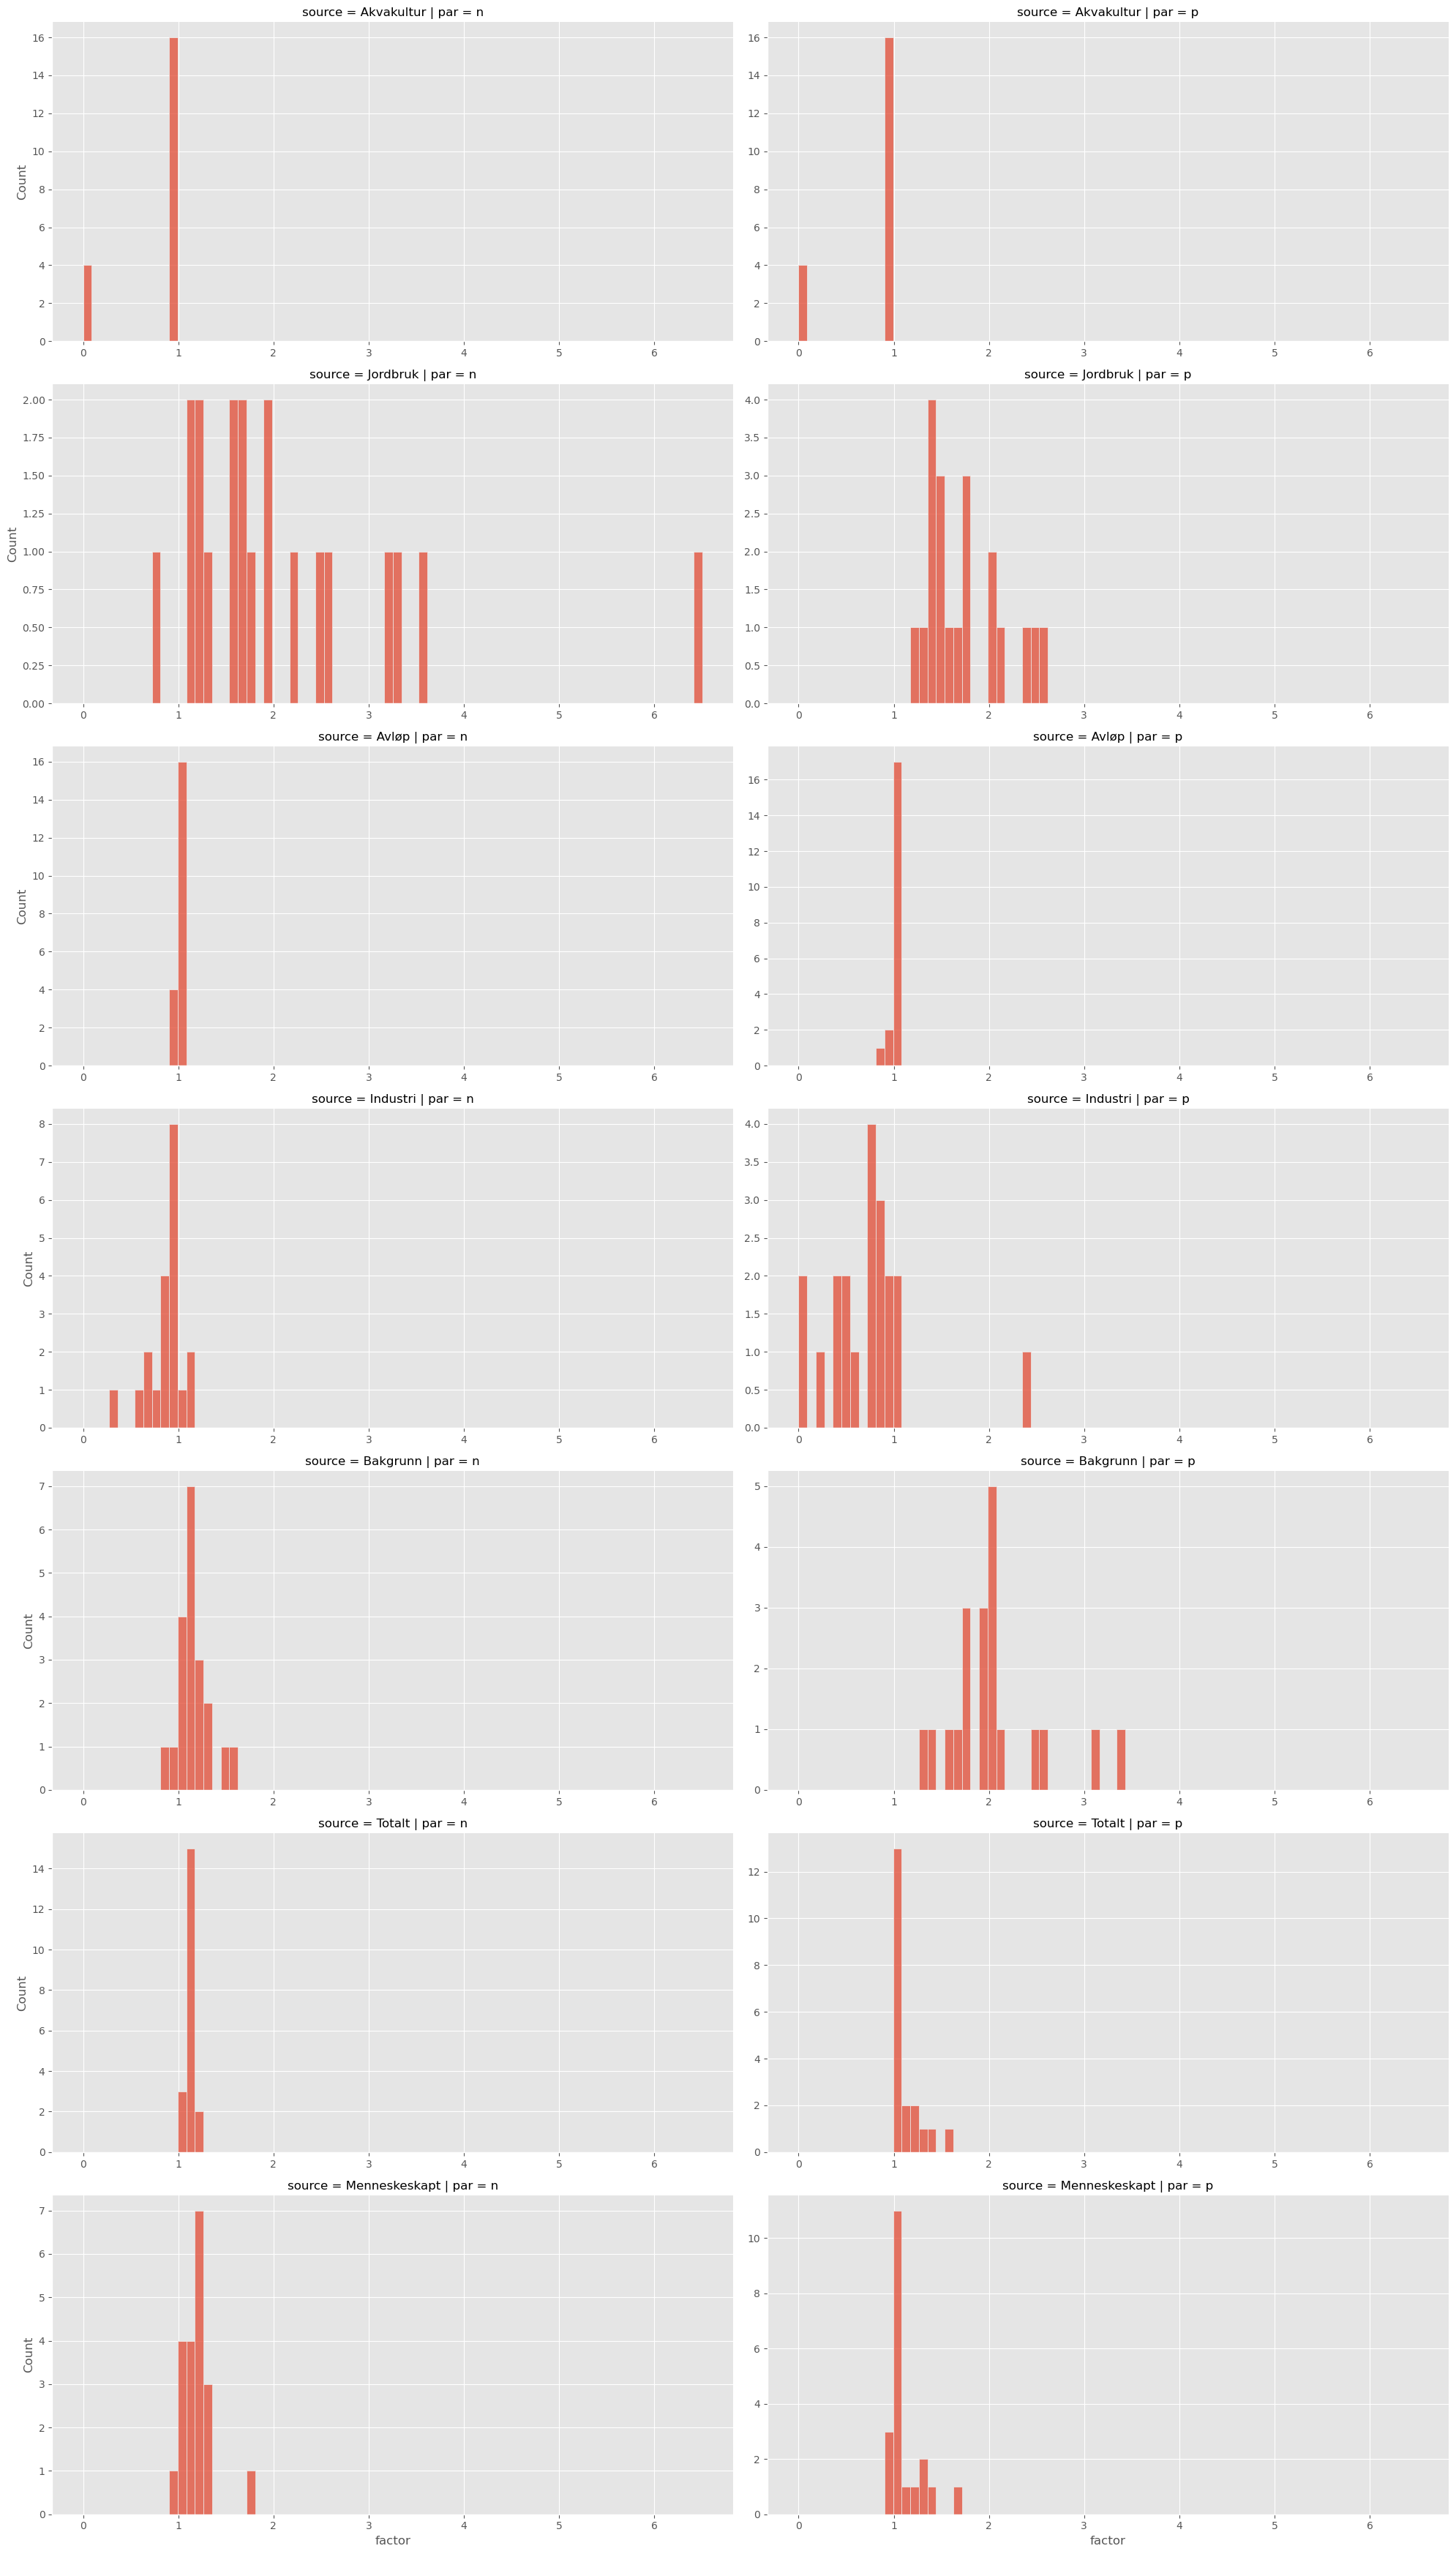

In [7]:
sn.displot(
    data=fac_df,
    x="factor",
    col="par",
    row="source",
    kind="hist",
    aspect=2,
    facet_kws={"sharex": False, "sharey": False},
)

In [8]:
fac_df.query(
    "(region == 'Indre Oslofjord') and (source not in ('Menneskeskapt', 'Totalt'))"
)[["source", "par", "factor"]].set_index(["source", "par"]).unstack("par").round(2)

factor      
par             n     p
source                 
Akvakultur   0.00  0.00
Avløp        1.00  1.03
Bakgrunn     1.62  1.92
Industri     0.78  0.00
Jordbruk     0.75  1.40

In [9]:
fac_df.query(
    "(region == 'Svenskegrensa – Lindesnes') and (source not in ('Menneskeskapt', 'Totalt'))"
)[["source", "par", "factor"]].set_index(["source", "par"]).unstack("par").round(2)

factor      
par             n     p
source                 
Akvakultur   0.98  0.98
Avløp        0.98  0.96
Bakgrunn     1.10  1.57
Industri     0.88  0.46
Jordbruk     1.25  1.74

## 4. Plots

In [10]:
# Save PNGs
plot_fold = r"/home/jovyan/shared/common/teotil3/teotil2_vs_teotil3_line_plots"

for area in teo2_res_dict["n"].keys():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for idx, par in enumerate(pars):
        df2 = teo2_res_dict[par][area].set_index("År")
        df2_cor = df2.query("År < 2013").copy()

        for col in df2_cor.columns:
            fac = fac_df.query(
                "(region == @area) and (par == @par) and (source == @col)"
            )["factor"].iloc[0]
            df2_cor[col] = fac * df2_cor[col]

        df3 = teo3_res_dict[par][area].set_index("År")
        df3 = pd.concat([df2_cor, df3], axis="rows").sort_index()

        df2.columns = [f"{col} (TEO2)" for col in df2.columns]
        df3.columns = [f"{col} (TEO3)" for col in df3.columns]
        df2.plot(ax=axes[idx], ls="--", legend=False)
        df3.plot(ax=axes[idx])
        axes[idx].set_title(f"{par.capitalize()} (tonnes)")
    plt.tight_layout()
    png_path = os.path.join(plot_fold, area + ".png")
    plt.savefig(png_path, dpi=200, bbox_inches="tight")
    plt.close()

In [11]:
# Save PDF
plot_fold = r"/home/jovyan/shared/common/teotil3/teotil2_vs_teotil3_line_plots"
pdf_path = os.path.join(plot_fold, "teo2_vs_teo3_1990-2022.pdf")

with PdfPages(pdf_path) as pdf:
    for area in teo2_res_dict["n"].keys():
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        for idx, par in enumerate(pars):
            df2 = teo2_res_dict[par][area].set_index("År")
            df2_cor = df2.query("År < 2013").copy()

            for col in df2_cor.columns:
                fac = fac_df.query(
                    "(region == @area) and (par == @par) and (source == @col)"
                )["factor"].iloc[0]
                df2_cor[col] = fac * df2_cor[col]

            df3 = teo3_res_dict[par][area].set_index("År")
            df3 = pd.concat([df2_cor, df3], axis="rows").sort_index()

            df2.columns = [f"{col} (TEO2)" for col in df2.columns]
            df3.columns = [f"{col} (TEO3)" for col in df3.columns]
            df2.plot(ax=axes[idx], ls="--", legend=False)
            df3.plot(ax=axes[idx], legend=False)
            axes[idx].set_title(f"{par.capitalize()} (tonnes)")
            if idx == 1:
                plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.suptitle(area)
        plt.tight_layout()
        pdf.savefig(fig, dpi=200, bbox_inches="tight")
        plt.close()

In [12]:
# Save PDF
plot_fold = r"/home/jovyan/shared/common/teotil3/teotil2_vs_teotil3_line_plots"
pdf_path = os.path.join(plot_fold, "teo2_vs_teo3_1990-2022_v2.pdf")

with PdfPages(pdf_path) as pdf:
    for area in teo2_res_dict["n"].keys():
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharey="row")
        for idx, par in enumerate(pars):
            df2 = teo2_res_dict[par][area].set_index("År")
            df2_cor = df2.query("År < 2013").copy()

            for col in df2_cor.columns:
                fac = fac_df.query(
                    "(region == @area) and (par == @par) and (source == @col)"
                )["factor"].iloc[0]
                df2_cor[col] = fac * df2_cor[col]

            df3 = teo3_res_dict[par][area].set_index("År")
            df3 = pd.concat([df2_cor, df3], axis="rows").sort_index()

            df2.plot(ax=axes[idx, 0], legend=False)
            df3.plot(ax=axes[idx, 1], legend=False)
            axes[idx, 1].axvline(2013, c="k", ls="--", lw=0.5)
            axes[idx, 0].set_title(f"TEOTIL2 {par.capitalize()} (tonnes)", fontsize=10)
            axes[idx, 1].set_title(f"TEOTIL3 {par.capitalize()} (tonnes)", fontsize=10)
            if idx == 1:
                plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
            axes[idx, 0].set_xlabel("")
            axes[idx, 1].set_xlabel("")
        plt.suptitle(area)
        plt.tight_layout()
        pdf.savefig(fig, dpi=200, bbox_inches="tight")
        plt.close()

In [13]:
# Save to Excel
xl_path = r"/home/jovyan/shared/common/teotil3/teotil2_vs_teotil3_line_plots/teo2_vs_teo3_data_tables.xlsx"

with pd.ExcelWriter(xl_path, engine="openpyxl") as writer:
    for area in teo2_res_dict["n"].keys():
        for idx, par in enumerate(pars):
            df2 = teo2_res_dict[par][area].set_index("År")
            df2.columns = [f"{col} (TEO2)" for col in df2.columns]
            df3 = teo3_res_dict[par][area].set_index("År")
            df3.columns = [f"{col} (TEO3)" for col in df3.columns]
            df_combined = df2.join(df3, how="outer")
            df_combined.to_excel(writer, sheet_name=f"{area} ({par.capitalize()})")